In [1]:
import datetime
import time
from typing import Any
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units


import src.nzthermo as nzt

Pa = units.pascal
K = units.kelvin

In [2]:
# load data
isobaric = xr.open_dataset(
    "data/hrrr.t00z.wrfprsf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "isobaricInhPa"}},
)

surface = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface", "stepType": "instant"}},
)

T = isobaric["t"].to_numpy()  # (K) (Z, Y, X)
Z, Y, X = T.shape
N = Y * X
T = T.reshape(Z, N).transpose()  # (N, Z)

P = isobaric["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0  # (Pa)
Q = isobaric["q"].to_numpy()  # (kg/kg) (Z, Y, X)
Q = Q.reshape(Z, N).transpose()  # (N, Z)
Td = nzt.dewpoint_from_specific_humidity(P, Q)

latitude = isobaric["latitude"].to_numpy()
longitude = isobaric["longitude"].to_numpy()
longitude = (longitude + 180) % 360 - 180
timestamp = datetime.datetime.fromisoformat(isobaric["time"].to_numpy().astype(str).item())

extent = [longitude.min(), longitude.max(), latitude.min(), latitude.max()]

Ignoring index file 'data/hrrr.t00z.wrfprsf00.grib2.9093e.idx' incompatible with GRIB file
Ignoring index file 'data/hrrr.t00z.wrfsfcf00.grib2.9093e.idx' incompatible with GRIB file


In [3]:
def get_data(**sel: Any):
    ds = isobaric.sel(**sel)
    T = ds["t"].to_numpy()  # (K) (Z, Y, X)
    Z, Y, X = T.shape
    N = Y * X
    T = T.reshape(Z, N).transpose()  # (N, Z)
    P = ds["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0  # (Pa)
    Q = ds["q"].to_numpy()  # (kg/kg) (Z, Y, X)
    Q = Q.reshape(Z, N).transpose()  # (N, Z)
    Td = nzt.dewpoint_from_specific_humidity(P, Q)
    lat = ds["latitude"].to_numpy()
    lon = (ds["longitude"].to_numpy() + 180) % 360 - 180
    timestamp = datetime.datetime.fromisoformat(ds["time"].to_numpy().astype(str).item())
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]

    return (P, T, Td), (Z, Y, X), (lat, lon, timestamp, extent)

In [4]:
idx = np.argmax(surface["cape"].to_numpy().ravel())

t = T[idx:idx+1, :]
td = nzt.dewpoint_from_specific_humidity(P, Q[idx:idx+1, :])

cape, cin = nzt.cape_cin(P, t, td, nzt.parcel_profile(P, t[:, 0], td[:, 0]))
%timeit nzt.cape_cin(P, t, td, nzt.parcel_profile(P, t[:, 0], td[:, 0]))

K = units.K
Pa = units.Pa

p = P * Pa
t = T[idx, :] * K
q = Q[idx, :]
td = mpcalc.dewpoint_from_specific_humidity(p, q)

cape_, cin_ = mpcalc.cape_cin(p, t, td, mpcalc.parcel_profile(p, t[0], td[0]))
%timeit mpcalc.cape_cin(p, t, td, mpcalc.parcel_profile(p, t[0], td[0]))

np.testing.assert_allclose(cape, cape_.magnitude, rtol=1e-3)
np.testing.assert_allclose(cin, cin_.magnitude, rtol=1e-3)

642 µs ± 199 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.01 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
Td = nzt.dewpoint_from_specific_humidity(P[np.newaxis], Q)
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0]) # (N, Z)

In [6]:
CAPE, CIN = nzt.cape_cin(P, T, Td, prof)

CAPE = CAPE.reshape(Y, X)
CIN = CIN.reshape(Y, X)

/home/leaver/nzthermo/src/nzthermo/core.py:240: RuntimeWarning: All-NaN slice encountered
  (np.nanmin(EL.pressure, axis=1, keepdims=True) < lcl_p),


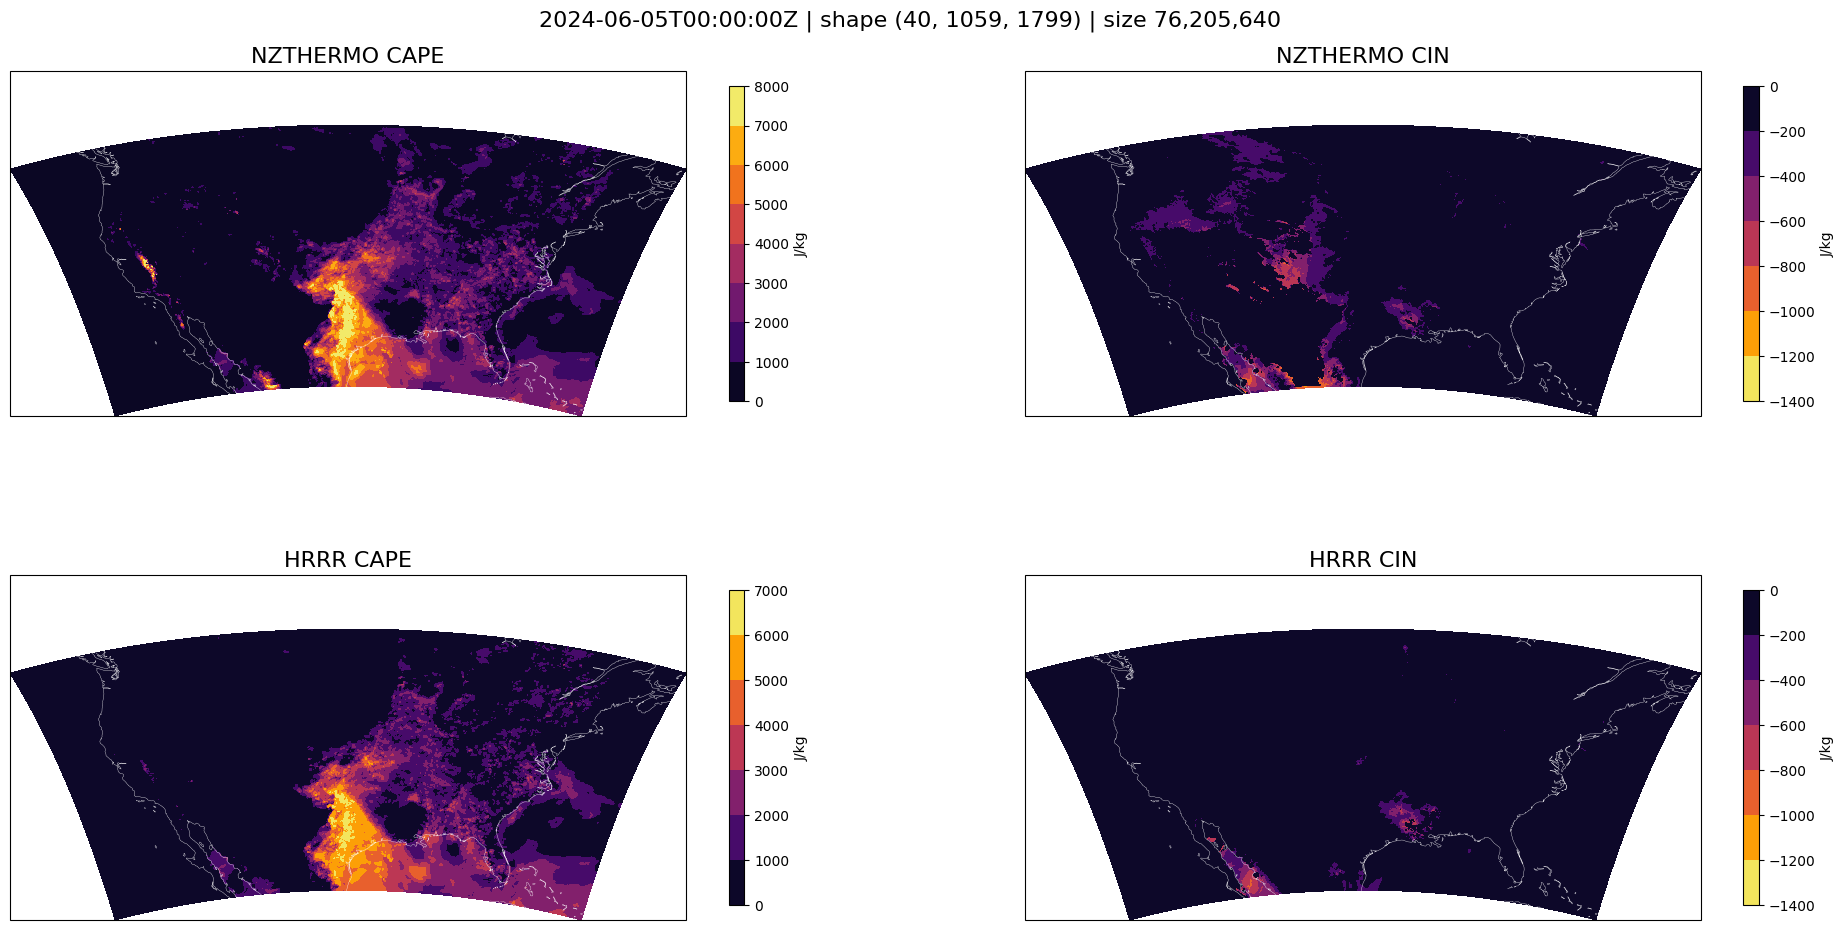

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), subplot_kw={"projection": ccrs.PlateCarree()})
fig.suptitle(f"{timestamp:%Y-%m-%dT%H:%M:%SZ} | shape {Z, Y, X} | size {Z*Y*X:,}", fontsize=16, y=0.9)
# I suspect that the difference between our cape calculations and the MRMS cape calculations is due
# to the fact we are not actually starting at the surface or accounting for surface elevation.
# leading to inflated cape values in areas of higher elevation.
cape = CAPE
cape = np.where(CAPE < 8000, CAPE, 8000)
cin = np.where(CIN > -1400, CIN, -1400)

for ax, data, title, cmap in zip(
    axes[0], [cape, cin], ["NZTHERMO CAPE", "NZTHERMO CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = surface["cape"].to_numpy()
HRRR_CIN = surface["cin"].to_numpy()
for ax, data, title, cmap in zip(
    axes[1], [HRRR_CAPE, HRRR_CIN], ["HRRR CAPE", "HRRR CIN"], ["inferno", "inferno_r"]
):
    ax.coastlines(color="white", linewidth=0.25)
    ax.set_title(title, fontsize=16)
    ax.set_extent(extent)
    cf = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap)
    plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)



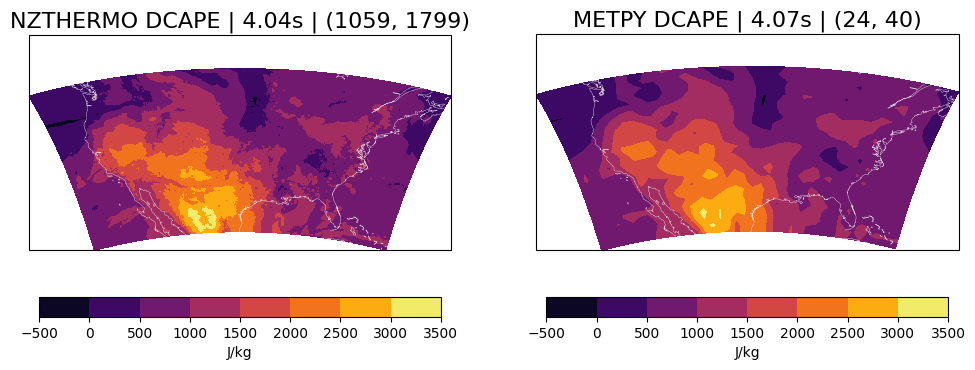

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})


# ............................................................................................... #
# nzthermo dcape
# ............................................................................................... #
ax = axes[0]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data()

start = time.time()
DCAPE = nzt.downdraft_cape(P, T, Td)
elapsed = time.time() - start

DCAPE = DCAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"NZTHERMO DCAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, DCAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95)
# ............................................................................................... #
# metpy dcape
# ............................................................................................... #
ax = axes[1]
(P, T, Td), (Z, Y, X), (latitude, longitude, timestamp, extent) = get_data(
    # we are plotting at a much lower resolution with metpy.
    x = slice(None, None, 45), 
    y = slice(None, None, 45),
)


P*= Pa
T*= K
Td *= K

start = time.time()
METPY_DCAPE = np.array([mpcalc.downdraft_cape(P, T[i, :], Td[i, :])[0].m for i in range(Y * X)])
elapsed = time.time() - start

METPY_DCAPE = METPY_DCAPE.reshape(Y, X)

ax.coastlines(color="white", linewidth=0.25)
ax.set_title(f"METPY DCAPE | {elapsed:.2f}s | {Y, X}", fontsize=16)
ax.set_extent(extent)
cf = ax.contourf(longitude, latitude, METPY_DCAPE, transform=ccrs.PlateCarree(), cmap="inferno")

plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, label="J/kg", shrink=0.95)